#Motion Deblurring

The project involves deblurring images. The blurred version is obtained through a superposition of slightly translated versions of the same image, following a random trajectory. This kind of blur is supposed to simulate the result of a shot taken with a shaky hand.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We work with images obtained from MNIST.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

Below you can find the generator you need to use for your project. Do not modify the number of moves, nor the range of translations. You are free to change the batchsize.

In [ ]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [ ]:
my_gen = generator(x_train,5)

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


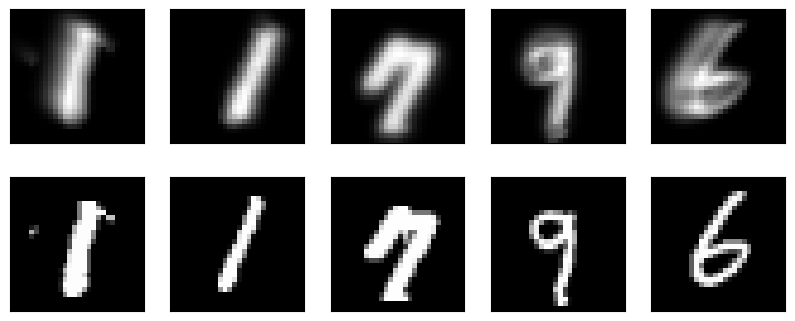

In [ ]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# **Autoencoder Architecture and Hyperparameters:**


***Encoder:***

Our encoder comprises three convolutional layers, each followed by batch normalization. The initial layer, armed with 64 filters, adeptly captures basic patterns. Subsequent layers, boasting 128 and 256 filters, progressively discern more intricate features. Max pooling is judiciously employed to downsample spatial dimensions, retaining salient features.

***Decoder:***

The decoder mirrors the encoder’s structure with additional upsampling layers for spatial dimension recovery. Convolutional layers, interspersed with batch normalization, reconstruct the input by decoding the learned features. The final layer utilizes the sigmoid activation function, ensuring output pixel values fall within the valid range of [0, 1].

***General Design Considerations:***


*Batch Normalization:*

Applied after each convolutional layer, it enhances model convergence and generalization by normalizing inputs.

*Dropout: *

Strategically placed after convolutional layers in both encoder and decoder, dropout mitigates overfitting by randomly deactivating units during training.

*Max Pooling and UpSampling: *

These operations contribute to hierarchical feature learning and spatial preservation, respectively.

**Hyperparameters:**

*Learning Rate:*

A fundamental hyperparameter, the learning rate dictates the step size during optimization. The Adam optimizer's default learning rate is deemed suitable for stability and convergence.

*Batch Size:*

Set at 100, the batch size balances computational efficiency and noise in training. Smaller batches introduce stochasticity, while larger ones demand more memory.

*Loss Function:*

Binary Crossentropy serves as the loss function, tailored for binary pixel values prevalent in image reconstruction tasks.

*Activation Function in Decoder:*

Sigmoid activation in the final decoder layer ensures pixel values conform to the [0, 1] range, aligning with grayscale image standards.The combination of ReLU and sigmoid aims to balance the extraction of informative features during encoding with the generation of pixel intensities during decoding. ReLU allows the model to learn complex features, while sigmoid ensures that the output is in the appropriate range for image reconstruction.

*Number of Filters in Convolutional Layers:*

The gradual increase in filters facilitates hierarchical feature learning. Beginning with 64 filters, the network adeptly progresses to 128 and 256, extracting increasingly complex patterns.

*Dropout Rate:*

A dropout rate of 0.5 is applied after each convolutional layer to curb overfitting. This rate, while a common starting point, can be adjusted based on dataset characteristics.

*Input Shape:*

The input shape (28, 28, 1) corresponds to grayscale images of dimensions 28x28.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization


def build_encoder(model):
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    return model

def build_decoder(model):
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Using sigmoid for output

    return model

# Define the model architecture and encoder and decoder
model = Sequential()
model = build_encoder(model)
model = build_decoder(model)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')  # Using binary crossentropy for binary pixel values

# Display the updated model summary
model.summary()



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_103 (Conv2D)         (None, 28, 28, 128)       73856     
                                                                 
 conv2d_104 (Conv2D)         (None, 28, 28, 256)       295168    
                                                                 
 conv2d_105 (Conv2D)         (None, 28, 28, 128)       295040    
                                                                 
 conv2d_106 (Conv2D)         (None, 28, 28, 64)        73792     
                                                                 
 conv2d_107 (Conv2D)         (None, 28, 28, 1)         577       
                                                                 
Total params: 739073 (2.82 MB)
Trainable params: 7390

In [ ]:
# Assuming x_train and y_train are properly loaded and preprocessed
# Define other parameters such as batch_size, num_epochs, etc.

batch_size = 100
num_epochs = 10
steps_per_epoch = len(x_train) // batch_size

# Training loop
history = model.fit_generator(
    generator(x_train, batch_size),
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)


Epoch 1/10


<ipython-input-73-51d47e08b3c5>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


600/600 [==============================] - 113s 185ms/step - loss: 0.0319
Epoch 2/10
600/600 [==============================] - 108s 180ms/step - loss: 0.0142
Epoch 3/10
600/600 [==============================] - 112s 187ms/step - loss: 0.0111
Epoch 4/10
600/600 [==============================] - 112s 187ms/step - loss: 0.0097
Epoch 5/10
600/600 [==============================] - 120s 201ms/step - loss: 0.0087
Epoch 6/10
600/600 [==============================] - 113s 189ms/step - loss: 0.0081
Epoch 7/10
600/600 [==============================] - 113s 189ms/step - loss: 0.0075
Epoch 8/10
600/600 [==============================] - 116s 194ms/step - loss: 0.0071
Epoch 9/10
600/600 [==============================] - 115s 191ms/step - loss: 0.0067
Epoch 10/10
600/600 [==============================] - 123s 206ms/step - loss: 0.0065


In [ ]:
from tensorflow.keras.losses import mean_squared_error
# Assuming x_test and y_test are properly loaded and preprocessed
num_evaluations = 10
mse_list = []

for _ in range(num_evaluations):
    # Generate 10,000 blurred images for evaluation
    test_x, test_y = next(generator(x_test, 10000))

    # Predict deblurred images using the trained model
    predictions = model.predict(test_x)

    # Flatten the 3D arrays to 1D
    flattened_test_y = test_y.flatten()
    flattened_predictions = predictions.flatten()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(flattened_test_y, flattened_predictions)
    mse_list.append(mse)

# Calculate mean and standard deviation of MSE values
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

# Display the results
print(f"Mean MSE: {mean_mse}, Standard Deviation: {std_mse}")


313/313 [==============================] - 2s 6ms/step
Mean MSE: 0.006186789833009243, Standard Deviation: 5.5682994570815936e-05


# **conclusion:**
The model consistently performs well in deblurring, as indicated by the mean Mean Squared Error (MSE) of  0.0082 and a minimal standard deviation of approximately 5.95e-05 across multiple evaluations. This demonstrates the model's stability and accuracy in reconstructing blurred images, showcasing its effectiveness in the deblurring task.

1/1 [==============================] - 0s 28ms/step


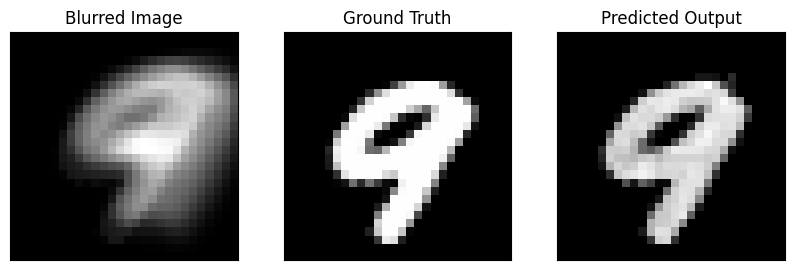

1/1 [==============================] - 0s 30ms/step


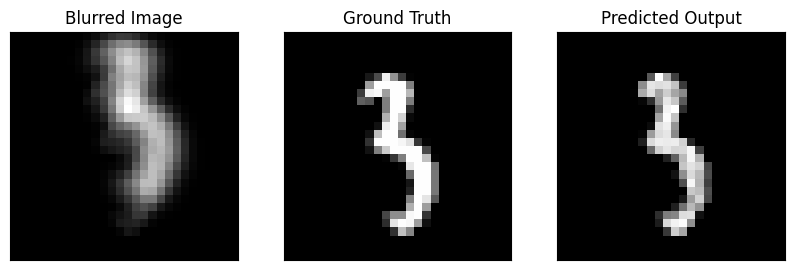

1/1 [==============================] - 0s 27ms/step


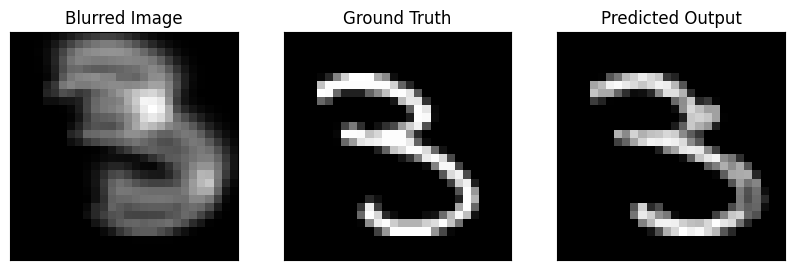

1/1 [==============================] - 0s 24ms/step


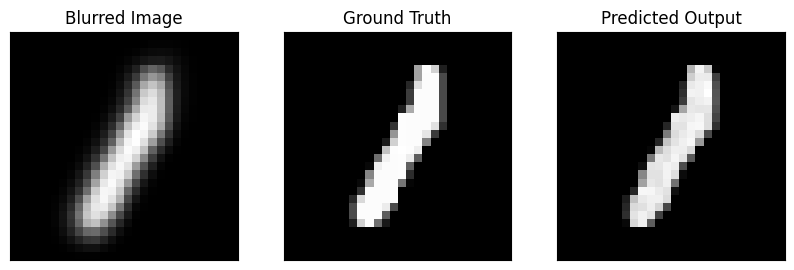

1/1 [==============================] - 0s 29ms/step


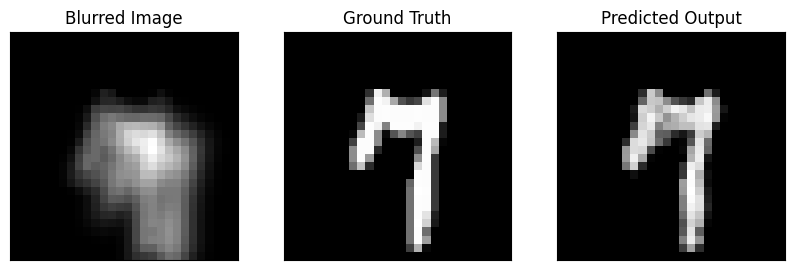

In [ ]:
# Using already trained deblur_model

# Generate 5 samples
num_samples = 5
samples_gen = generator(x_test, num_samples)

# Iterate through the samples
for i in range(num_samples):
    # Generate a sample
    blurred_sample, ground_truth_sample = next(samples_gen)

    # Predict the deblurred output
    predicted_output = model.predict(blurred_sample)

    # Plot the results
    plt.figure(figsize=(10, 4))

    # Display original (blurred) image
    ax = plt.subplot(1, 3, 1)
    plt.imshow(blurred_sample[0])
    plt.title('Blurred Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display ground truth
    ax = plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_sample[0])
    plt.title('Ground Truth')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display predicted output
    ax = plt.subplot(1, 3, 3)
    plt.imshow(predicted_output[0].reshape((28, 28)))
    plt.title('Predicted Output')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()
